In [131]:
from merge_years.import_data import get_full_data
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [132]:
raw_df = get_full_data('./raw_data/')
raw_df.sort_values(['name','kickoff_date'], inplace = True)

In [133]:
raw_df.head()

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,season,position,kickoff_date
0,aaron connolly,0,0,1,0,0.1,534,37,1,0,0.0,0.2,14:00:00,24,11,0,0,0,0,0,0,0.0,4.0,0.0,1,0,0,0,45,False,0,4,20,FWD,2019-08-31
1,aaron connolly,0,0,1,0,0.3,534,43,1,0,2.2,1.0,14:00:00,6,5,0,0,0,0,0,14029,1.0,1.0,21.0,1,10589,13500,2911,45,True,0,5,20,FWD,2019-09-14
2,aaron connolly,0,0,1,0,4.8,534,58,0,0,2.5,2.0,16:30:00,20,13,0,0,0,0,0,22804,0.0,0.0,18.0,1,8090,11749,3659,45,False,0,6,20,FWD,2019-09-21
3,aaron connolly,0,0,2,0,0.6,534,63,1,0,0.1,0.2,14:00:00,25,6,0,0,0,0,0,32699,0.0,2.0,0.0,1,8437,13439,5002,45,False,0,7,20,FWD,2019-09-28
4,aaron connolly,0,3,53,1,23.8,534,72,0,2,20.1,70.2,11:30:00,79,17,0,0,0,0,0,35026,0.0,3.0,107.0,13,2156,5952,3796,45,True,0,8,20,FWD,2019-10-05


In [134]:
raw_df = raw_df[~raw_df.position.isnull()]

In [135]:
def get_player_df(df,name):
    return df[df['name'] == name]

In [137]:
raw_df.dtypes

name                  object
assists                int64
bonus                  int64
bps                    int64
clean_sheets           int64
creativity           float64
element                int64
fixture                int64
goals_conceded         int64
goals_scored           int64
ict_index            float64
influence            float64
kickoff_time          object
minutes                int64
opponent_team          int64
own_goals              int64
penalties_missed       int64
penalties_saved        int64
red_cards              int64
saves                  int64
selected               int64
team_a_score         float64
team_h_score         float64
threat               float64
total_points           int64
transfers_balance      int64
transfers_in           int64
transfers_out          int64
value                  int64
was_home                bool
yellow_cards           int64
GW                     int64
season                 int64
position              object
kickoff_date  

In [138]:
features = ['name','assists','bonus','goals_scored','goals_conceded',
            'opponent_team','transfers_balance','was_home','position',
           'saves','value','kickoff_date','total_points']
subset_df = raw_df[features]
train_df = subset_df[subset_df.kickoff_date < pd.to_datetime('2021-01-01')]
test_df = subset_df[subset_df.kickoff_date >= pd.to_datetime('2021-01-01')]

In [139]:
game_counts = train_df.groupby('name').count()['assists']
rookies = np.unique(game_counts[game_counts < 15].index)
print(f"Removing {len(rookies)} rookies out of {len(train_df.name.unique())} players")
train_df = train_df[~train_df.name.isin(rookies)]

Removing 132 rookies out of 1431 players


# Functions

In [140]:
def subsample_sequence(df, length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    # $CHALLENGIFY_BEGIN
    last_possible = df.shape[0] - length
    
    random_start = random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]
    # $CHALLENGIFY_END
    return df_sample

def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()
    
    # Case if ALL values of at least one feature of X are NaN, then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)
        
    return means

def split_subsample_sequence(df, length, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    
    y_sample = df_subsample.iloc[length-1]['total_points']
    # Case y_sample is NaN: redraw !
    if y_sample != y_sample: # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values
        
    return np.array(X_sample), np.array(y_sample)

def get_X_y(df, n_sequences, length):
    '''Return a list of samples (X, y)'''
    # $CHALLENGIFY_BEGIN
    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)
    # $CHALLENGIFY_END
    return X, y

In [141]:
train_df.was_home = train_df.was_home.map(int)

In [142]:
train_df

,name,assists,bonus,goals_scored,goals_conceded,opponent_team,transfers_balance,was_home,position,saves,value,kickoff_date,total_points
0,aaron connolly,0,0,0,1,11,0,0,FWD,0,45,2019-08-31,1
1,aaron connolly,0,0,0,1,5,10589,1,FWD,0,45,2019-09-14,1
2,aaron connolly,0,0,0,0,13,8090,0,FWD,0,45,2019-09-21,1
3,aaron connolly,0,0,0,1,6,8437,0,FWD,0,45,2019-09-28,1
4,aaron connolly,0,3,2,0,17,2156,1,FWD,0,45,2019-10-05,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114908,ørjan nyland,0,0,0,0,20,-15335,0,GK,0,40,2020-12-12,0
114909,ørjan nyland,0,0,0,0,4,-13413,1,GK,0,40,2020-12-17,0
114910,ørjan nyland,0,0,0,0,18,-14973,0,GK,0,40,2020-12-20,0
114911,ørjan nyland,0,0,0,0,6,-16168,1,GK,0,40,2020-12-26,0


In [143]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
train_df.position = enc.fit_transform(train_df[['position']])

In [144]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
train_df.transfers_balance = ss.fit_transform(train_df[['transfers_balance']])
train_df = train_df.drop(columns = ['kickoff_date'])

Minimum history for players:1


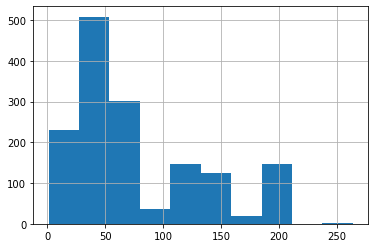

In [145]:
print(f"Minimum history for players:{raw_df.groupby('name').count()['assists'].min()}")
raw_df.groupby('name').count()['assists'].hist()

In [152]:
players = train_df.name.unique()

In [157]:
def get_sequences(n_seq,length):
    list_X = []
    list_y = []
    for player in players:
        df = get_player_df(train_df,player)
        X,y = get_X_y(df.drop('name',axis = 1), n_seq, length)
        list_X.append(X)
        list_y.append(y)
    return np.concatenate(list_X), np.concatenate(list_y)

In [158]:
X_train, Y_train = get_sequences(8,6)

In [159]:
print(X_train.shape)
print(Y_train.shape)

(10392, 5, 11)
(10392,)


# Model

In [168]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

def init_model():
    
    model = models.Sequential()
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh', input_shape=(5,11)))
    model.add(layers.LSTM(10, return_sequences=True, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer='rmsprop', 
                  metrics=['mae'])
    model.compile(loss='mse', 
                  optimizer=RMSprop(learning_rate=0.0003), 
                  metrics=['mae'])
    
    return model

init_model().summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 5, 20)             2560      
_________________________________________________________________
lstm_15 (LSTM)               (None, 5, 10)             1240      
_________________________________________________________________
dense_14 (Dense)             (None, 5, 5)              55        
_________________________________________________________________
dense_15 (Dense)             (None, 5, 1)              6         
Total params: 3,861
Trainable params: 3,861
Non-trainable params: 0
_________________________________________________________________


In [171]:
from tensorflow.keras.callbacks import EarlyStopping

model = init_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

history = model.fit(X_train, Y_train,
            validation_split=0.2,
            epochs= 500, 
            batch_size=64,
            callbacks=[es], verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping


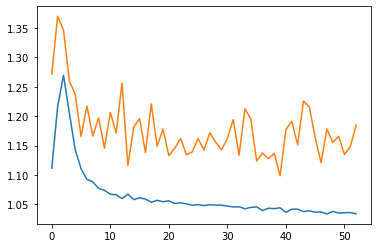

In [172]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])